In [1]:
import pandas as pd
from dateutil.relativedelta import relativedelta
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
import math
import os
from datetime import date, timedelta, datetime
import time
from tqdm import tqdm
# import pyodbc6
import seaborn as sns
from scipy import stats
import xlsxwriter
from matplotlib.ticker import MaxNLocator
from matplotlib.backends.backend_pdf import PdfPages
start_time = time.perf_counter()
from scipy.stats import zscore

In [2]:
mapping = pd.read_excel("company_master_mapping.xlsx")
# price_data = d.fetch_price_data(no_of_years=20)
price_data = pd.read_csv('stockPriceData.csv')
# Convert 'Date' to datetime type
price_data['Date'] = pd.to_datetime(price_data['Date'])

# Create a dictionary mapping from SYMBOL_NSE to SYMBOL_CM
mapping = dict(zip(mapping["SYMBOL_NSE"], mapping["SYMBOL_CM"]))
price_data["Symbol"] = price_data["Symbol"].replace(mapping)

top_500 =  price_data.groupby('Date', group_keys= False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(1000))
# Filter price data for dates after '2006-01-01' and drop duplicates
price_data.drop_duplicates(['Date', 'Symbol'], inplace=True)

price_data['Mcap'] = price_data['Mcap'] / 10
#company master swapping
# company_master = d.fetch_data_from_database(table_name='Companymaster')
company_master = pd.read_csv('Companymaster.csv')
company_master["SYMBOL"] = company_master["SYMBOL"].replace(mapping)


# shareholding =  pd.read_csv('Shpsummary.csv')
# shareholding = shareholding[['FINCODE','DATE_END','tpFtotalpromoter']]
# shareholding = shareholding.rename(columns={'tpFtotalpromoter' : 'PromoterHolding'})
# shareholding=pd.merge(shareholding,company_master,how='outer',on='FINCODE')
# shareholding.dropna(inplace=True)
# shareholding=shareholding[shareholding['DATE_END']!=0]

shareholding =  pd.read_csv('Shpsummary_28_4_2025.csv')
shareholding = shareholding[['FINCODE','DATE_END','tpFtotalpromoter']]
shareholding = shareholding.rename(columns={'tpFtotalpromoter' : 'PromoterHolding'})
shareholding['PromoterHolding'] = shareholding['PromoterHolding'].fillna(0)
shareholding=pd.merge(shareholding,company_master,how='outer',on='FINCODE')
shareholding.dropna(inplace=True)
shareholding=shareholding[shareholding['DATE_END']!=0]


In [3]:
rebal_dates=pd.read_csv('growth_date_5_5_2025.csv')
rebal_dates["Date"] = pd.to_datetime(rebal_dates["Date"])
rebal_dates['Qtr'] = rebal_dates['Qtr'].astype('int')

def previousQuarter(currDate):

    if pd.Period(currDate,freq = "Q").end_time.date() == currDate.date():
        return currDate
    else:
        return currDate - pd.offsets.QuarterEnd()

shareholding["DATE_END"] = pd.to_datetime(shareholding['DATE_END'],format="%Y%m")
# ## Shift Date to respective Month End date.
shareholding["MonthEnd"] = shareholding["DATE_END"] + pd.offsets.MonthEnd()
shareholding["QuarterEnd"] = shareholding["MonthEnd"].apply(previousQuarter)

## Convert the Dates as per Indian Financial Quarter
shareholding["YearQuarter"] = shareholding["QuarterEnd"].dt.to_period("Q-Mar")
shareholding["Year"] = shareholding["YearQuarter"].dt.year

## sort the Data Frame based on Quarter
shareholding.sort_values("YearQuarter", ascending =
True, inplace = 
True)

shareholding.reset_index(drop = True, inplace =
True)

shareholding['FreeFloat']=100-shareholding['PromoterHolding']
shareholding['YearQuarter']=shareholding['YearQuarter'].astype(str)
shareholding['Quarter']=shareholding['YearQuarter'].str[-2:]+shareholding['YearQuarter'].str[:-2]

shareholding=pd.merge(shareholding,rebal_dates,left_on='Quarter',right_on='Quarter')
finalShareHolding=shareholding[['Date','SYMBOL','PromoterHolding','FreeFloat']]
finalShareHolding =  finalShareHolding.rename(columns={'SYMBOL' : 'Symbol'})

In [4]:
top_500=pd.merge(top_500,finalShareHolding,on=['Date','Symbol'],how='left')
top_500[['PromoterHolding','FreeFloat']]=top_500.groupby('Symbol')[['PromoterHolding','FreeFloat']].ffill()
top_500['FreeFloat'] = top_500['FreeFloat'] / 100
top_500['FreeFloatMcap']=top_500['FreeFloat']*top_500['Mcap']
top_500['FreeFloatMcap']=np.where(top_500['FreeFloatMcap'].isna(),top_500['Mcap'],top_500['FreeFloatMcap'])
top_500.drop(columns=['PromoterHolding','FreeFloat'],inplace=True)

In [5]:
top_500 =  top_500.groupby('Date', group_keys= False).apply(lambda x: x.sort_values(by='Mcap', ascending=False).head(500))
top_500

,Date,Symbol,Open,High,Low,Close,Volume,Mcap,FreeFloatMcap
0,1995-06-07,RELIANCE,14.219753,14.244921,13.942908,13.980660,1736500.0,127867.712506,127867.712506
1,1995-06-07,TATASTEEL,13.306368,13.348477,12.941425,12.986341,535150.0,78210.356961,78210.356961
2,1995-06-07,HINDPETRO,34.074074,34.074074,33.604938,34.074074,2100.0,66074.400000,66074.400000
3,1995-06-07,GRASIM,134.485258,135.043040,134.465337,134.465337,850.0,48811.929750,48811.929750
4,1995-06-07,NESTLEIND,23.000000,23.000000,22.866667,22.866667,200.0,22047.060392,22047.060392
...,...,...,...,...,...,...,...,...,...
5414832,2025-06-06,JPPOWER,15.840000,16.750000,15.730000,16.240000,92688605.0,111300.171350,84588.130226
5414833,2025-06-06,INOXINDIA,1230.000000,1243.600000,1213.200000,1220.200000,73579.0,110749.622700,110749.622700
5414834,2025-06-06,SAREGAMA,582.000000,582.500000,565.100000,573.500000,375708.0,110576.242515,44783.378219
5414835,2025-06-06,MMTC,75.400000,75.490000,72.500000,73.570000,1298041.0,110355.000000,11112.748500


In [6]:
# Calculate FreeFloatMcap weight as a percentage
top_500['FreeFloatMcap_Weight'] = top_500.groupby('Date')['FreeFloatMcap'].transform(lambda x: x / x.sum()) * 100
top_500 = top_500.sort_values(by=['Date','FreeFloatMcap_Weight'], ascending=[True,False])
top_500

,Date,Symbol,Open,High,Low,Close,Volume,Mcap,FreeFloatMcap,FreeFloatMcap_Weight
0,1995-06-07,RELIANCE,14.219753,14.244921,13.942908,13.980660,1736500.0,127867.712506,127867.712506,34.405166
1,1995-06-07,TATASTEEL,13.306368,13.348477,12.941425,12.986341,535150.0,78210.356961,78210.356961,21.043939
2,1995-06-07,HINDPETRO,34.074074,34.074074,33.604938,34.074074,2100.0,66074.400000,66074.400000,17.778536
3,1995-06-07,GRASIM,134.485258,135.043040,134.465337,134.465337,850.0,48811.929750,48811.929750,13.133750
4,1995-06-07,NESTLEIND,23.000000,23.000000,22.866667,22.866667,200.0,22047.060392,22047.060392,5.932168
...,...,...,...,...,...,...,...,...,...,...
5414749,2025-06-06,ACMESOLAR,254.000000,254.650000,249.200000,250.850000,258526.0,151786.269864,25181.342170,0.010390
5414811,2025-06-06,ABDL,429.950000,433.300000,418.500000,428.450000,1059718.0,119841.814196,22877.802330,0.009439
5414546,2025-06-06,UCOBANK,34.000000,34.490000,32.140000,32.940000,40883060.0,413053.072768,19041.746655,0.007857
5414835,2025-06-06,MMTC,75.400000,75.490000,72.500000,73.570000,1298041.0,110355.000000,11112.748500,0.004585


In [7]:
SectorThemeGICS = pd.read_csv('Company Classification.csv')
top_500 = pd.merge(top_500, SectorThemeGICS[['Symbol', 'Sector']], left_on='Symbol', right_on='Symbol', how='left')
top_500

,Date,Symbol,Open,High,Low,Close,Volume,Mcap,FreeFloatMcap,FreeFloatMcap_Weight,Sector
0,1995-06-07,RELIANCE,14.219753,14.244921,13.942908,13.980660,1736500.0,127867.712506,127867.712506,34.405166,"Oil, Gas & Consumable Fuels"
1,1995-06-07,TATASTEEL,13.306368,13.348477,12.941425,12.986341,535150.0,78210.356961,78210.356961,21.043939,Metals & Mining
2,1995-06-07,HINDPETRO,34.074074,34.074074,33.604938,34.074074,2100.0,66074.400000,66074.400000,17.778536,"Oil, Gas & Consumable Fuels"
3,1995-06-07,GRASIM,134.485258,135.043040,134.465337,134.465337,850.0,48811.929750,48811.929750,13.133750,Construction Materials
4,1995-06-07,NESTLEIND,23.000000,23.000000,22.866667,22.866667,200.0,22047.060392,22047.060392,5.932168,Fast Moving Consumer Goods
...,...,...,...,...,...,...,...,...,...,...,...
2963603,2025-06-06,ACMESOLAR,254.000000,254.650000,249.200000,250.850000,258526.0,151786.269864,25181.342170,0.010390,Power
2963604,2025-06-06,ABDL,429.950000,433.300000,418.500000,428.450000,1059718.0,119841.814196,22877.802330,0.009439,Fast Moving Consumer Goods
2963605,2025-06-06,UCOBANK,34.000000,34.490000,32.140000,32.940000,40883060.0,413053.072768,19041.746655,0.007857,Financial Services
2963606,2025-06-06,MMTC,75.400000,75.490000,72.500000,73.570000,1298041.0,110355.000000,11112.748500,0.004585,Services


<Figure size 1600x800 with 0 Axes>

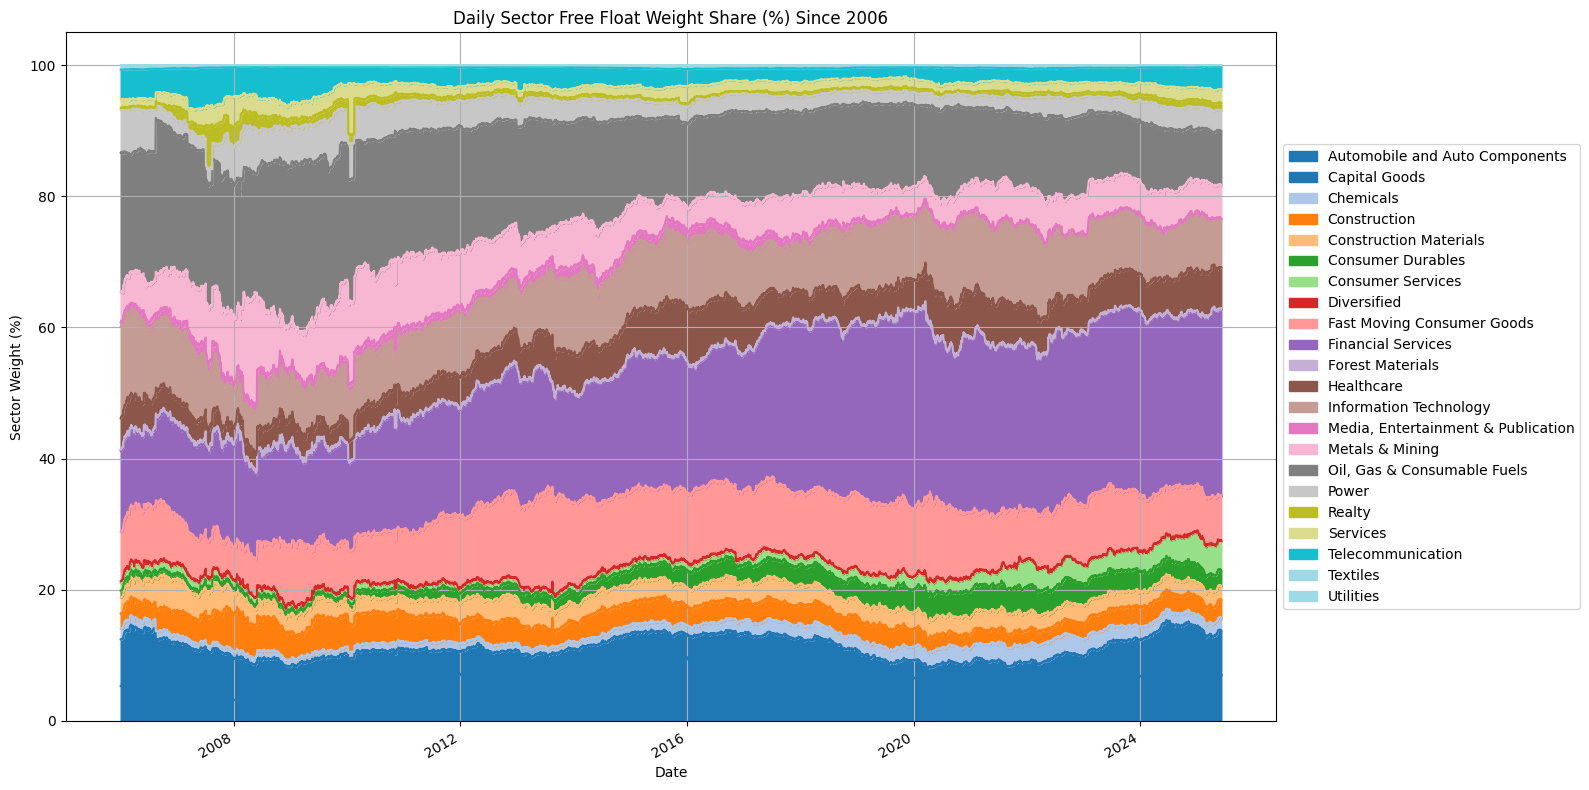

In [8]:
# Step 1: Convert Date column to datetime and filter
top_500["Date"] = pd.to_datetime(top_500["Date"])
top_500 = top_500[top_500["Date"] >= "2006-01-01"]

# Step 2: Group by Date and Sector, summing the free float market cap weight
daily_sector_weights = top_500.groupby(["Date", "Sector"])["FreeFloatMcap_Weight"].sum().unstack(fill_value=0)

# Step 3: Normalize weights to sum to 100% per day (optional but good for share plot)
daily_sector_weights = daily_sector_weights.div(daily_sector_weights.sum(axis=1), axis=0) * 100

# Step 4: Plot stacked area chart
plt.figure(figsize=(16, 8))
daily_sector_weights.plot(kind="area", stacked=True, figsize=(16, 8), cmap="tab20")
plt.title("Daily Sector Free Float Weight Share (%) Since 2006")
plt.ylabel("Sector Weight (%)")
plt.xlabel("Date")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.grid(True)
plt.show()

In [9]:
# Show the last date's sector weights (as percentage)
last_row = daily_sector_weights.iloc[-1]
print("Free Float Weights on", last_row.name.date())
print(last_row.sort_values(ascending=False).round(2))

Free Float Weights on 2025-06-06
Sector
Financial Services                    28.54
Oil, Gas & Consumable Fuels            8.25
Information Technology                 7.34
Automobile and Auto Components         7.01
Fast Moving Consumer Goods             6.73
Capital Goods                          6.69
Healthcare                             6.29
Metals & Mining                        5.11
Consumer Services                      4.54
Telecommunication                      3.47
Power                                  3.12
Construction                           2.72
Consumer Durables                      2.37
Construction Materials                 2.10
Services                               2.04
Chemicals                              1.92
Realty                                 1.20
Textiles                               0.23
Diversified                            0.12
Forest Materials                       0.11
Media, Entertainment & Publication     0.09
Utilities                           

In [10]:
# Step 1: Reset index to prepare for merge
daily_sector_weights_reset = daily_sector_weights.reset_index()

# Step 2: Melt daily sector weights to long format
sector_weights_long = daily_sector_weights_reset.melt(id_vars='Date', 
                                                       var_name='Sector', 
                                                       value_name='DailySectorFFWeight')

# Step 3: Merge back with the original top_500 DataFrame
top_500 = pd.merge(top_500, sector_weights_long, on=["Date", "Sector"], how="left")
top_500

,Date,Symbol,Open,High,Low,Close,Volume,Mcap,FreeFloatMcap,FreeFloatMcap_Weight,Sector,DailySectorFFWeight
0,2006-01-02,ONGC,131.444444,133.055556,129.555556,132.405556,831613.0,1.699214e+06,1.699214e+06,7.635784,"Oil, Gas & Consumable Fuels",21.335905
1,2006-01-02,RELIANCE,89.899042,90.805079,89.612130,90.387295,3661821.0,1.251161e+06,1.251161e+06,5.622362,"Oil, Gas & Consumable Fuels",21.335905
2,2006-01-02,NTPC,93.666667,93.708333,92.083333,92.500000,435719.0,9.152465e+05,9.152465e+05,4.112857,Power,6.533968
3,2006-01-02,INFY,187.937500,187.937500,185.812500,186.209375,415500.0,8.179065e+05,8.179065e+05,3.675439,Information Technology,13.943442
4,2006-01-02,TCS,213.500000,213.862500,210.168750,210.950000,206688.0,8.102418e+05,8.102418e+05,3.640995,Information Technology,13.943442
...,...,...,...,...,...,...,...,...,...,...,...,...
2396495,2025-06-06,ACMESOLAR,254.000000,254.650000,249.200000,250.850000,258526.0,1.517863e+05,2.518134e+04,0.010390,Power,3.119143
2396496,2025-06-06,ABDL,429.950000,433.300000,418.500000,428.450000,1059718.0,1.198418e+05,2.287780e+04,0.009439,Fast Moving Consumer Goods,6.734974
2396497,2025-06-06,UCOBANK,34.000000,34.490000,32.140000,32.940000,40883060.0,4.130531e+05,1.904175e+04,0.007857,Financial Services,28.540447
2396498,2025-06-06,MMTC,75.400000,75.490000,72.500000,73.570000,1298041.0,1.103550e+05,1.111275e+04,0.004585,Services,2.041354


In [11]:
port = pd.read_csv('FinalPortDF.csv')
port['Date'] = pd.to_datetime(port['Date'])
port = pd.merge(port,top_500[['Date','Symbol','FreeFloatMcap','FreeFloatMcap_Weight','Sector','DailySectorFFWeight']], on=['Date','Symbol'])
port

,Date,Symbol,Close,Mcap,Avg_6M_Mcap,Alpha,Beta,FreeFloatMcap,FreeFloatMcap_Weight,Sector,DailySectorFFWeight
0,2007-01-10,ONGC,148.425000,1.904773e+06,1.731586e+06,-0.000397,0.885772,1.904773e+06,9.205178,"Oil, Gas & Consumable Fuels",21.283584
1,2007-01-10,RELIANCE,157.649340,1.774145e+06,1.622570e+06,0.001276,1.027597,8.884917e+05,4.293805,"Oil, Gas & Consumable Fuels",21.283584
2,2007-01-10,TCS,308.850000,1.208975e+06,1.033335e+06,0.000582,0.900854,1.977884e+05,0.955850,Information Technology,10.533583
3,2007-01-10,INFY,270.556250,1.207435e+06,1.086317e+06,0.000623,0.860071,9.740379e+05,4.707224,Information Technology,10.533583
4,2007-01-10,BHARTIARTL,277.236604,1.163339e+06,9.448303e+05,0.001474,0.865488,4.540511e+05,2.194288,Telecommunication,3.998727
...,...,...,...,...,...,...,...,...,...,...,...
2144315,2025-05-06,ANURAS,880.900000,9.683851e+04,8.067699e+04,0.000517,0.482089,3.759271e+04,0.016466,Chemicals,1.919277
2144316,2025-05-06,INDIACEM,310.350000,9.617660e+04,9.866770e+04,0.001315,0.994950,9.617660e+04,0.042126,Construction Materials,2.271345
2144317,2025-05-06,SAFARI,1962.100000,9.592029e+04,1.111496e+05,0.000188,0.545281,5.236289e+04,0.022935,Consumer Durables,2.496056
2144318,2025-05-06,ARVIND,365.200000,9.561592e+04,9.547602e+04,0.000679,0.937789,5.776158e+04,0.025300,Textiles,0.253833


In [12]:
import cvxpy as cp
# print(cp.installed_solvers())

In [13]:
port = port.dropna()
port

,Date,Symbol,Close,Mcap,Avg_6M_Mcap,Alpha,Beta,FreeFloatMcap,FreeFloatMcap_Weight,Sector,DailySectorFFWeight
0,2007-01-10,ONGC,148.425000,1.904773e+06,1.731586e+06,-0.000397,0.885772,1.904773e+06,9.205178,"Oil, Gas & Consumable Fuels",21.283584
1,2007-01-10,RELIANCE,157.649340,1.774145e+06,1.622570e+06,0.001276,1.027597,8.884917e+05,4.293805,"Oil, Gas & Consumable Fuels",21.283584
2,2007-01-10,TCS,308.850000,1.208975e+06,1.033335e+06,0.000582,0.900854,1.977884e+05,0.955850,Information Technology,10.533583
3,2007-01-10,INFY,270.556250,1.207435e+06,1.086317e+06,0.000623,0.860071,9.740379e+05,4.707224,Information Technology,10.533583
4,2007-01-10,BHARTIARTL,277.236604,1.163339e+06,9.448303e+05,0.001474,0.865488,4.540511e+05,2.194288,Telecommunication,3.998727
...,...,...,...,...,...,...,...,...,...,...,...
2144315,2025-05-06,ANURAS,880.900000,9.683851e+04,8.067699e+04,0.000517,0.482089,3.759271e+04,0.016466,Chemicals,1.919277
2144316,2025-05-06,INDIACEM,310.350000,9.617660e+04,9.866770e+04,0.001315,0.994950,9.617660e+04,0.042126,Construction Materials,2.271345
2144317,2025-05-06,SAFARI,1962.100000,9.592029e+04,1.111496e+05,0.000188,0.545281,5.236289e+04,0.022935,Consumer Durables,2.496056
2144318,2025-05-06,ARVIND,365.200000,9.561592e+04,9.547602e+04,0.000679,0.937789,5.776158e+04,0.025300,Textiles,0.253833


In [171]:
import pandas as pd

def allocate_weights_for_date(df_date):
    df_date = df_date.copy()

    # Get sector target weights
    sector_targets = df_date[['Sector', 'DailySectorFFWeight']].drop_duplicates().set_index('Sector')['DailySectorFFWeight']

    results = []

    for sector, target_weight in sector_targets.items():
        # Subset data for the sector and sort by Alpha
        sector_df = df_date[df_date['Sector'] == sector].copy()
        sector_df = sector_df[sector_df['Alpha'] > 0]  # Optional: Only keep positive alpha

        if sector_df.empty or target_weight == 0:
            continue

        # Sort stocks in descending order of Alpha
        sector_df = sector_df.sort_values(by='Alpha', ascending=False)

        # Compute cumulative sum of weights based on FreeFloatMcap_Weight
        sector_df['cumsum_ffmcap'] = sector_df['FreeFloatMcap_Weight'].cumsum()
        total_ffmcap = sector_df['FreeFloatMcap_Weight'].sum()
        sector_df['ffmcap_weight_share'] = sector_df['FreeFloatMcap_Weight'] / total_ffmcap

        # Assign weight proportional to FF weight * target sector weight
        sector_df['Weight'] = sector_df['ffmcap_weight_share'] * target_weight

        results.append(sector_df[['Date', 'Symbol', 'Alpha', 'Sector', 'Weight']])

    combined = pd.concat(results)

    # Normalize entire portfolio to sum to 1 (in case sector weights had rounding issues)
    combined['Weight'] /= combined['Weight'].sum()

    return combined

def allocate_weights(df):
    return pd.concat(
        [allocate_weights_for_date(group) for _, group in df.groupby('Date')],
        ignore_index=True
    )

# Usage:
portfolio_weights = allocate_weights(port)

In [ ]:
import pandas as pd

def allocate_weights_for_date(df_date):
    df_date = df_date.copy()

    # Get sector target weights
    sector_targets = df_date[['Sector', 'DailySectorFFWeight']].drop_duplicates().set_index('Sector')['DailySectorFFWeight']

    results = []

    for sector, target_weight in sector_targets.items():
        # Subset for the sector and filter positive alpha
        sector_df = df_date[df_date['Sector'] == sector].copy()
        sector_df = sector_df[sector_df['Alpha'] > 0]

        if sector_df.empty or target_weight == 0:
            continue

        # Alpha-weighted allocation within sector
        total_alpha = sector_df['Alpha'].sum()
        sector_df['Weight'] = (sector_df['Alpha'] / total_alpha) * target_weight

        results.append(sector_df[['Date', 'Symbol', 'Alpha', 'Sector', 'Weight']])

    combined = pd.concat(results)

    # Normalize total weight to 1, if needed (optional safeguard)
    combined['Weight'] /= combined['Weight'].sum()

    return combined

def allocate_weights(df):
    return pd.concat(
        [allocate_weights_for_date(group) for _, group in df.groupby('Date')],
        ignore_index=True
    )

# Example usage
portfolio_weights = allocate_weights(port)

In [20]:
import pandas as pd
import cvxpy as cp
import numpy as np

def optimize_portfolio(df_date):
    df = df_date.copy()
    df = df[df['Alpha'] > 0].reset_index(drop=True)

    date_str = df['Date'].iloc[0] if not df.empty else 'N/A'
    n = len(df)
    if n == 0:
        print(f"[!] No positive alpha stocks on {date_str}")
        return pd.DataFrame(columns=['Date', 'Symbol', 'Alpha', 'Sector', 'Weight'])

    w = cp.Variable(n)
    alpha = df['Alpha'].values

    constraints = [w >= 0.001,  # Relaxed lower bound
                   w <= 0.03,
                   cp.sum(w) == 1]

    objective = cp.Maximize(cp.sum(w * alpha))
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if w.value is None:
        print(f"[X] Optimization failed on {date_str}")
        return pd.DataFrame(columns=['Date', 'Symbol', 'Alpha', 'Sector', 'Weight'])

    df['Weight'] = w.value
    print(f"[✓] Optimization succeeded on {date_str} — Total weight: {df['Weight'].sum():.4f}")
    return df[['Date', 'Symbol', 'Alpha', 'Sector', 'Weight']]


In [21]:
df_one_date = port[port['Date'] == '2020-06-10']
optimized_result = optimize_portfolio(df_one_date)
optimized_result.groupby('Sector')['Weight'].sum().sort_values(ascending=False)


[✓] Optimization succeeded on 2020-06-10 00:00:00 — Total weight: 1.0000


Sector
Healthcare                            0.364000
Consumer Durables                     0.139999
Chemicals                             0.112000
Capital Goods                         0.087000
Oil, Gas & Consumable Fuels           0.040000
Power                                 0.036000
Textiles                              0.036000
Consumer Services                     0.036000
Telecommunication                     0.033001
Financial Services                    0.029000
Fast Moving Consumer Goods            0.025000
Information Technology                0.015000
Automobile and Auto Components        0.011000
Services                              0.009000
Construction Materials                0.007000
Realty                                0.006000
Construction                          0.004000
Metals & Mining                       0.004000
Media, Entertainment & Publication    0.003000
Diversified                           0.003000
Name: Weight, dtype: float64

In [17]:
df_one_date = port[port['Date'] == '2020-06-10']
positive_alpha = df_one_date[df_one_date['Alpha'] > 0]

print(f"Date: {df_one_date['Date'].iloc[0]}")
print(f"Total stocks with Alpha > 0: {len(positive_alpha)}")
print(f"Max possible portfolio weight = {len(positive_alpha) * 0.03:.2f}")
print(f"Min possible portfolio weight = {len(positive_alpha) * 0.01:.2f}")


Date: 2020-06-10 00:00:00
Total stocks with Alpha > 0: 276
Max possible portfolio weight = 8.28
Min possible portfolio weight = 2.76


In [37]:
master_date = price_data.drop_duplicates(subset='Date')[['Date']].reset_index(drop=True)
# Define the start date (it should start from 2006-06-19)
start_date = pd.to_datetime('2006-06-19')

# Filter the dates starting from 2006-06-19 (this ensures the start date is included)
filtered_dates = master_date[master_date['Date'] >= start_date]

# Ensure the start date is included
start_date_row = filtered_dates[filtered_dates['Date'] == start_date]

# Select every 50th date from the filtered dates (starting from the filtered list after the start date)
selected_dates = filtered_dates.iloc[::22]

# Combine the start date with the selected dates
selected_dates = pd.concat([start_date_row, selected_dates])

# Drop any NaN values and sort by date to ensure it's in the correct order
selected_dates = selected_dates.dropna().sort_values(by='Date')

combined_dates_portfolio = port[port['Date'].isin(selected_dates['Date'])]
combined_dates_portfolio

,Date,Symbol,Close,Mcap,Avg_6M_Mcap,Alpha,Beta,FreeFloatMcap,FreeFloatMcap_Weight,Sector,DailySectorFFWeight
8653,2007-02-09,RELIANCE,172.341320,1.939484e+06,1.703417e+06,0.001636,1.025477,9.712938e+05,4.092670,"Oil, Gas & Consumable Fuels",20.453787
8654,2007-02-09,ONGC,147.316667,1.890549e+06,1.784959e+06,-0.000482,0.883382,1.890549e+06,7.966071,"Oil, Gas & Consumable Fuels",20.453787
8656,2007-02-09,BHARTIARTL,339.740774,1.425676e+06,1.044946e+06,0.001956,0.879673,5.564414e+05,2.344637,Telecommunication,4.451005
8657,2007-02-09,INFY,295.156250,1.317220e+06,1.141782e+06,0.001092,0.836229,1.062601e+06,4.477405,Information Technology,10.688605
8658,2007-02-09,TCS,321.850000,1.259863e+06,1.092154e+06,0.000819,0.915508,2.061136e+05,0.868486,Information Technology,10.688605
...,...,...,...,...,...,...,...,...,...,...,...
2138660,2025-04-15,TEGA,1461.000000,9.720835e+04,1.069972e+05,0.000538,0.946110,2.449651e+04,0.011041,Capital Goods,6.099546
2138661,2025-04-15,OLECTRA,1179.900000,9.684706e+04,1.141630e+05,-0.002101,1.492486,4.840416e+04,0.021817,Automobile and Auto Components,6.865368
2138662,2025-04-15,MEDPLUS,804.200000,9.625778e+04,8.985344e+04,0.001095,0.315054,5.737926e+04,0.025862,Consumer Services,4.534466
2138663,2025-04-15,MARKSANS,211.010000,9.562208e+04,1.206218e+05,0.001253,1.335836,5.367267e+04,0.024192,Healthcare,6.596078


In [ ]:
# import pandas as pd
# import numpy as np
# from scipy.optimize import minimize
# import warnings
# warnings.filterwarnings('ignore')

# class VariableStockOptimizer:
#     def __init__(self, min_stock_weight=0.01, max_stock_weight=0.03, 
#                  stocks_per_sector=20, min_total_stocks=20, max_total_stocks=100):
#         """
#         Variable stock count optimizer - let the math decide how many stocks to include
        
#         Parameters:
#         min_stock_weight: Minimum weight per included stock (1%)
#         max_stock_weight: Maximum weight per stock (3%)
#         stocks_per_sector: Max candidate stocks to consider per sector
#         min_total_stocks: Minimum total stocks in final portfolio
#         max_total_stocks: Maximum total stocks in final portfolio (100 at 1% each)
#         """
#         self.min_stock_weight = min_stock_weight
#         self.max_stock_weight = max_stock_weight
#         self.stocks_per_sector = stocks_per_sector
#         self.min_total_stocks = min_total_stocks
#         self.max_total_stocks = max_total_stocks
#         self.sector_multiplier_min = 0.5  # 0.5x index weight
#         self.sector_multiplier_max = 1.5  # 1.5x index weight
        
#     def create_candidate_universe(self, date_data):
#         """
#         Create candidate universe: top N stocks per sector by alpha
#         """
#         candidate_stocks = []
        
#         print(f"Creating candidate universe...")
#         print(f"Target: Top {self.stocks_per_sector} stocks per sector")
        
#         sector_counts = {}
        
#         for sector in date_data['Sector'].unique():
#             sector_data = date_data[date_data['Sector'] == sector].copy()
#             sector_data = sector_data.sort_values('Alpha', ascending=False)
            
#             # Take top stocks from this sector
#             n_to_take = min(len(sector_data), self.stocks_per_sector)
#             sector_candidates = sector_data.head(n_to_take)
            
#             candidate_stocks.append(sector_candidates)
#             sector_counts[sector] = len(sector_candidates)
            
#             print(f"  {sector}: {len(sector_candidates)} candidates (alpha: {sector_candidates['Alpha'].min():.4f} to {sector_candidates['Alpha'].max():.4f})")
        
#         # Combine all candidates
#         if candidate_stocks:
#             candidate_universe = pd.concat(candidate_stocks, ignore_index=True)
#             print(f"\nTotal candidate universe: {len(candidate_universe)} stocks")
#             return candidate_universe, sector_counts
#         else:
#             return None, {}
    
#     def get_sector_constraints(self, candidate_universe):
#         """
#         Calculate sector weight constraints for the candidate universe
#         """
#         sector_info = candidate_universe.groupby('Sector').agg({
#             'DailySectorFFWeight': 'first'
#         }).reset_index()
        
#         sector_info['IndexWeight'] = sector_info['DailySectorFFWeight'] / 100.0
#         sector_info['MinWeight'] = sector_info['IndexWeight'] * self.sector_multiplier_min
#         sector_info['MaxWeight'] = sector_info['IndexWeight'] * self.sector_multiplier_max
        
#         # Create sector stock mapping
#         sector_stock_mapping = {}
#         for sector in sector_info['Sector']:
#             stock_indices = candidate_universe[candidate_universe['Sector'] == sector].index.tolist()
#             sector_stock_mapping[sector] = stock_indices
            
#         return sector_info, sector_stock_mapping
    
#     def optimize_with_variable_stocks(self, port_df, target_date):
#         """
#         Main optimization with variable stock count
#         """
#         print(f"Variable Stock Count Optimization for {target_date}")
#         print("=" * 70)
        
#         # Filter for target date
#         date_data = port_df[port_df['Date'] == target_date].copy()
        
#         if len(date_data) == 0:
#             return {'status': 'failed', 'error': f'No data for {target_date}'}
            
#         # Remove missing data
#         date_data = date_data.dropna(subset=['Alpha', 'Sector', 'DailySectorFFWeight'])
#         print(f"Available stocks after cleaning: {len(date_data)}")
        
#         # Create candidate universe
#         candidate_universe, sector_counts = self.create_candidate_universe(date_data)
        
#         if candidate_universe is None:
#             return {'status': 'failed', 'error': 'Could not create candidate universe'}
        
#         # Get sector constraints
#         sector_info, sector_stock_mapping = self.get_sector_constraints(candidate_universe)
        
#         print(f"\nSector constraints:")
#         for _, row in sector_info.iterrows():
#             candidates_in_sector = len(sector_stock_mapping[row['Sector']])
#             print(f"  {row['Sector']}: {row['MinWeight']:.1%} - {row['MaxWeight']:.1%} (Index: {row['IndexWeight']:.1%}) - {candidates_in_sector} candidates")
        
#         # Set up optimization
#         n_candidates = len(candidate_universe)
#         alphas = candidate_universe['Alpha'].values
        
#         print(f"\nOptimization setup:")
#         print(f"  Candidate stocks: {n_candidates}")
#         print(f"  Alpha range: {alphas.min():.4f} to {alphas.max():.4f}")
#         print(f"  Weight bounds: {self.min_stock_weight:.1%} to {self.max_stock_weight:.1%}")
        
#         # Initial guess: equal weights for all candidates (will be very low)
#         x0 = np.full(n_candidates, 1.0 / n_candidates)
        
#         # Bounds: 0% to max_weight (allowing stocks to be excluded with 0% weight)
#         bounds = [(0.0, self.max_stock_weight) for _ in range(n_candidates)]
        
#         # Constraints
#         constraints = []
        
#         # Portfolio must sum to approximately 100%
#         constraints.append({
#             'type': 'eq',
#             'fun': lambda w: np.sum(w) - 1.0
#         })
        
#         # Sector weight constraints
#         for _, row in sector_info.iterrows():
#             sector = row['Sector']
#             stock_indices = sector_stock_mapping[sector]
            
#             if len(stock_indices) > 0:
#                 # Minimum sector weight
#                 constraints.append({
#                     'type': 'ineq',
#                     'fun': lambda w, indices=stock_indices, min_w=row['MinWeight']: 
#                            np.sum([w[i] for i in indices]) - min_w
#                 })
                
#                 # Maximum sector weight
#                 constraints.append({
#                     'type': 'ineq',
#                     'fun': lambda w, indices=stock_indices, max_w=row['MaxWeight']: 
#                            max_w - np.sum([w[i] for i in indices])
#                 })
        
#         # Objective: maximize alpha-weighted returns
#         def objective(weights):
#             return -np.sum(weights * alphas)
        
#         # Run optimization
#         try:
#             print(f"\nRunning optimization...")
            
#             result = minimize(
#                 fun=objective,
#                 x0=x0,
#                 method='SLSQP',
#                 bounds=bounds,
#                 constraints=constraints,
#                 options={'maxiter': 2000, 'ftol': 1e-9}
#             )
            
#             if result.success:
#                 raw_weights = result.x
                
#                 # Post-process: Apply minimum weight rule
#                 # Any stock with weight > 0 but < min_weight gets rounded to 0
#                 # Then redistribute the freed-up weight
#                 processed_weights = self.post_process_weights(raw_weights, alphas)
                
#                 # Create results
#                 results_df = candidate_universe.copy()
#                 results_df['RawWeight'] = raw_weights
#                 results_df['OptimalWeight'] = processed_weights
#                 results_df['WeightPct'] = processed_weights * 100
#                 results_df['Included'] = processed_weights > 0
                
#                 # Filter to only included stocks
#                 included_stocks = results_df[results_df['Included']].copy()
                
#                 print(f"\nOptimization Results:")
#                 print(f"  Total candidates: {len(results_df)}")
#                 print(f"  Stocks included: {len(included_stocks)}")
#                 print(f"  Inclusion rate: {len(included_stocks)/len(results_df):.1%}")
#                 print(f"  Final total weight: {included_stocks['OptimalWeight'].sum():.1%}")
                
#                 # Sector analysis
#                 sector_results = []
#                 for _, row in sector_info.iterrows():
#                     sector = row['Sector']
#                     sector_stocks = included_stocks[included_stocks['Sector'] == sector]
                    
#                     if len(sector_stocks) > 0:
#                         sector_weight = sector_stocks['OptimalWeight'].sum()
                        
#                         sector_results.append({
#                             'Sector': sector,
#                             'IndexWeight': row['IndexWeight'],
#                             'OptimalWeight': sector_weight,
#                             'MinBound': row['MinWeight'],
#                             'MaxBound': row['MaxWeight'],
#                             'WithinBounds': row['MinWeight'] <= sector_weight <= row['MaxWeight'],
#                             'StockCount': len(sector_stocks),
#                             'CandidateCount': len(sector_stock_mapping[sector]),
#                             'InclusionRate': len(sector_stocks) / len(sector_stock_mapping[sector]),
#                             'AvgAlpha': sector_stocks['Alpha'].mean(),
#                             'AvgWeight': sector_stocks['OptimalWeight'].mean()
#                         })
                
#                 sector_results_df = pd.DataFrame(sector_results)
                
#                 return {
#                     'date': target_date,
#                     'status': 'success',
#                     'portfolio': included_stocks,
#                     'all_candidates': results_df,
#                     'sector_analysis': sector_results_df,
#                     'total_weight': included_stocks['OptimalWeight'].sum(),
#                     'alpha_weighted_return': np.sum(included_stocks['OptimalWeight'] * included_stocks['Alpha']),
#                     'num_stocks_included': len(included_stocks),
#                     'num_candidates': len(results_df)
#                 }
#             else:
#                 return {'status': 'failed', 'error': result.message}
                
#         except Exception as e:
#             return {'status': 'error', 'error': str(e)}
    
#     def post_process_weights(self, raw_weights, alphas):
#         """
#         Post-process weights to enforce minimum weight rule
#         """
#         processed_weights = raw_weights.copy()
        
#         # Find stocks that are included but below minimum weight
#         small_weights_mask = (processed_weights > 0) & (processed_weights < self.min_stock_weight)
        
#         if np.any(small_weights_mask):
#             print(f"  Post-processing: {np.sum(small_weights_mask)} stocks below minimum weight")
            
#             # Free up weight from small positions
#             freed_weight = np.sum(processed_weights[small_weights_mask])
#             processed_weights[small_weights_mask] = 0
            
#             # Redistribute freed weight to remaining stocks proportional to their alpha
#             remaining_mask = processed_weights >= self.min_stock_weight
            
#             if np.any(remaining_mask):
#                 remaining_alphas = alphas[remaining_mask]
#                 remaining_weights = processed_weights[remaining_mask]
                
#                 # Only redistribute to stocks that have room (below max weight)
#                 room_available = self.max_stock_weight - remaining_weights
#                 redistributable_mask = room_available > 0.001
                
#                 if np.any(redistributable_mask):
#                     # Weight redistribution by alpha, respecting max weight constraints
#                     alpha_weights = remaining_alphas[redistributable_mask]
#                     alpha_weights = alpha_weights / np.sum(alpha_weights)  # Normalize
                    
#                     additional_weights = freed_weight * alpha_weights
                    
#                     # Make sure we don't exceed max weights
#                     room = room_available[redistributable_mask]
#                     additional_weights = np.minimum(additional_weights, room)
                    
#                     # Apply the additional weights
#                     remaining_indices = np.where(remaining_mask)[0]
#                     redistributable_indices = remaining_indices[redistributable_mask]
                    
#                     processed_weights[redistributable_indices] += additional_weights
                    
#                     remaining_freed = freed_weight - np.sum(additional_weights)
#                     if remaining_freed > 0.001:
#                         print(f"  Warning: {remaining_freed:.1%} weight could not be redistributed")
        
#         return processed_weights

# def run_variable_stock_optimization(port_df, target_date='2025-05-06', 
#                                    stocks_per_sector=20, min_weight=0.01, max_weight=0.03):
#     """
#     Run optimization with variable stock count
#     """
#     target_date = pd.to_datetime(target_date)
    
#     # Initialize optimizer
#     optimizer = VariableStockOptimizer(
#         min_stock_weight=min_weight,
#         max_stock_weight=max_weight,
#         stocks_per_sector=stocks_per_sector,
#         min_total_stocks=20,
#         max_total_stocks=100
#     )
    
#     # Run optimization
#     result = optimizer.optimize_with_variable_stocks(port_df, target_date)
    
#     if result['status'] == 'success':
#         print(f"\n✅ Variable Stock Optimization Successful!")
        
#         portfolio = result['portfolio']
#         sector_analysis = result['sector_analysis']
        
#         print(f"\n📊 PORTFOLIO SUMMARY:")
#         print(f"   • Stocks included: {result['num_stocks_included']} (from {result['num_candidates']} candidates)")
#         print(f"   • Total weight: {result['total_weight']:.1%}")
#         print(f"   • Alpha-weighted return: {result['alpha_weighted_return']:.4f}")
#         print(f"   • Weight range: {portfolio['OptimalWeight'].min():.1%} - {portfolio['OptimalWeight'].max():.1%}")
#         print(f"   • Average weight per stock: {portfolio['OptimalWeight'].mean():.1%}")
        
#         # Top holdings
#         print(f"\n⭐ TOP 10 HOLDINGS:")
#         top_holdings = portfolio.nlargest(10, 'OptimalWeight')[
#             ['Symbol', 'Sector', 'Alpha', 'WeightPct']
#         ]
#         print(top_holdings.to_string(index=False, formatters={
#             'Alpha': '{:.4f}'.format,
#             'WeightPct': '{:.2f}%'.format
#         }))
        
#         # Sector allocation
#         print(f"\n🎯 SECTOR ALLOCATION:")
#         sector_display = sector_analysis.copy()
#         sector_display['IndexWeightPct'] = sector_display['IndexWeight'] * 100
#         sector_display['OptimalWeightPct'] = sector_display['OptimalWeight'] * 100
        
#         for _, row in sector_display.iterrows():
#             inclusion_rate = row['InclusionRate'] * 100
#             print(f"   • {row['Sector'][:25]:<25}: {row['OptimalWeightPct']:5.1f}% (vs {row['IndexWeightPct']:4.1f}% index) - {row['StockCount']:2d}/{row['CandidateCount']:2d} stocks ({inclusion_rate:4.0f}%)")
        
#         # Constraint compliance
#         all_sectors_compliant = sector_analysis['WithinBounds'].all()
#         weights_in_bounds = (
#             (portfolio['OptimalWeight'] >= optimizer.min_stock_weight - 0.001) & 
#             (portfolio['OptimalWeight'] <= optimizer.max_stock_weight + 0.001)
#         ).all()
        
#         print(f"\n✅ CONSTRAINT COMPLIANCE:")
#         print(f"   • All sector constraints satisfied: {'✅' if all_sectors_compliant else '❌'}")
#         print(f"   • All stock weight constraints satisfied: {'✅' if weights_in_bounds else '❌'}")
#         print(f"   • Total weight constraint: {'✅' if abs(result['total_weight'] - 1.0) < 0.01 else '❌'}")
        
#         return result
    
#     else:
#         print(f"❌ Optimization failed: {result.get('error', 'Unknown error')}")
#         return None

# def compare_different_parameters(port_df, target_date='2025-05-06'):
#     """
#     Compare results with different parameter settings
#     """
#     print("Comparing Different Parameter Settings")
#     print("=" * 70)
    
#     parameter_sets = [
#         {'stocks_per_sector': 15, 'min_weight': 0.01, 'max_weight': 0.03, 'name': 'Conservative (15/sector, 1%-3%)'},
#         {'stocks_per_sector': 20, 'min_weight': 0.01, 'max_weight': 0.03, 'name': 'Balanced (20/sector, 1%-3%)'},
#         {'stocks_per_sector': 25, 'min_weight': 0.01, 'max_weight': 0.04, 'name': 'Aggressive (25/sector, 1%-4%)'},
#         {'stocks_per_sector': 30, 'min_weight': 0.005, 'max_weight': 0.05, 'name': 'Very Aggressive (30/sector, 0.5%-5%)'},
#     ]
    
#     results = []
    
#     for params in parameter_sets:
#         print(f"\nTesting: {params['name']}")
#         print("-" * 50)
        
#         result = run_variable_stock_optimization(
#             port_df, target_date, 
#             stocks_per_sector=params['stocks_per_sector'],
#             min_weight=params['min_weight'],
#             max_weight=params['max_weight']
#         )
        
#         if result and result['status'] == 'success':
#             results.append((params['name'], result))
#             print(f"✅ Success: {result['num_stocks_included']} stocks, Alpha return: {result['alpha_weighted_return']:.4f}")
#         else:
#             print(f"❌ Failed")
    
#     if results:
#         print(f"\n" + "="*70)
#         print(f"COMPARISON SUMMARY")
#         print("="*70)
        
#         comparison_data = []
#         for name, result in results:
#             comparison_data.append({
#                 'Setting': name,
#                 'Stocks': result['num_stocks_included'],
#                 'Alpha_Return': result['alpha_weighted_return'],
#                 'Min_Weight': result['portfolio']['OptimalWeight'].min(),
#                 'Max_Weight': result['portfolio']['OptimalWeight'].max(),
#                 'Avg_Weight': result['portfolio']['OptimalWeight'].mean(),
#                 'Sectors_Compliant': result['sector_analysis']['WithinBounds'].sum()
#             })
        
#         comparison_df = pd.DataFrame(comparison_data)
#         print(comparison_df.to_string(index=False, formatters={
#             'Alpha_Return': '{:.4f}'.format,
#             'Min_Weight': '{:.1%}'.format,
#             'Max_Weight': '{:.1%}'.format,
#             'Avg_Weight': '{:.1%}'.format
#         }))
        
#         # Best by alpha return
#         best_result = max(results, key=lambda x: x[1]['alpha_weighted_return'])
#         print(f"\n🏆 Best by Alpha Return: {best_result[0]}")
#         print(f"   Alpha Return: {best_result[1]['alpha_weighted_return']:.4f}")
#         print(f"   Number of stocks: {best_result[1]['num_stocks_included']}")
        
#         return results
    
#     return []

# # Usage examples
# if __name__ == "__main__":
#     print("Variable Stock Count Portfolio Optimizer")
#     print("=" * 60)
#     print("\nKey Features:")
#     print("• No fixed stock count - optimizer decides how many stocks to include")
#     print("• Each included stock gets at least 1% weight")
#     print("• Maximum 100 stocks possible (100 × 1% = 100%)")
#     print("• Sector constraints: 0.5x to 1.5x index weights")
#     print("• Maximizes alpha-weighted returns")
#     print("\nTo run with your port DataFrame:")
#     print("result = run_variable_stock_optimization(port, '2025-05-06')")
#     print("\nTo compare different settings:")
#     print("results = compare_different_parameters(port, '2025-05-06')")

Variable Stock Count Portfolio Optimizer

Key Features:
• No fixed stock count - optimizer decides how many stocks to include
• Each included stock gets at least 1% weight
• Maximum 100 stocks possible (100 × 1% = 100%)
• Sector constraints: 0.5x to 1.5x index weights
• Maximizes alpha-weighted returns

To run with your port DataFrame:
result = run_variable_stock_optimization(port, '2025-05-06')

To compare different settings:
results = compare_different_parameters(port, '2025-05-06')


In [ ]:
# # Test the Variable Stock Count Optimizer with your port DataFrame

# print("🚀 Testing Variable Stock Count Optimizer")
# print("=" * 60)

# # Run the main optimization
# result = run_variable_stock_optimization(port, '2025-05-06', 
#                                         stocks_per_sector=20, 
#                                         min_weight=0.01, 
#                                         max_weight=0.03)

# # Save results if successful
# if result and result['status'] == 'success':
#     print(f"\n💾 Saving results to Excel...")
    
#     # Create comprehensive Excel output
#     with pd.ExcelWriter('variable_stock_portfolio_2025_05_06.xlsx', engine='openpyxl') as writer:
        
#         # Sheet 1: Final Portfolio (only included stocks)
#         portfolio = result['portfolio'].copy()
#         portfolio_output = portfolio[
#             ['Symbol', 'Sector', 'Alpha', 'OptimalWeight', 'WeightPct', 
#              'Close', 'Mcap', 'DailySectorFFWeight']
#         ].sort_values('OptimalWeight', ascending=False)
#         portfolio_output.to_excel(writer, sheet_name='Final_Portfolio', index=False)
        
#         # Sheet 2: All Candidates (showing inclusion decisions)
#         candidates = result['all_candidates'].copy()
#         candidates_output = candidates[
#             ['Symbol', 'Sector', 'Alpha', 'RawWeight', 'OptimalWeight', 
#              'WeightPct', 'Included']
#         ].sort_values('Alpha', ascending=False)
#         candidates_output.to_excel(writer, sheet_name='All_Candidates', index=False)
        
#         # Sheet 3: Sector Analysis
#         sector_analysis = result['sector_analysis'].copy()
#         sector_analysis['IndexWeightPct'] = sector_analysis['IndexWeight'] * 100
#         sector_analysis['OptimalWeightPct'] = sector_analysis['OptimalWeight'] * 100
#         sector_analysis['MinBoundPct'] = sector_analysis['MinBound'] * 100
#         sector_analysis['MaxBoundPct'] = sector_analysis['MaxBound'] * 100
#         sector_analysis['InclusionRatePct'] = sector_analysis['InclusionRate'] * 100
        
#         sector_output = sector_analysis[[
#             'Sector', 'StockCount', 'CandidateCount', 'InclusionRatePct',
#             'IndexWeightPct', 'OptimalWeightPct', 'MinBoundPct', 'MaxBoundPct',
#             'WithinBounds', 'AvgAlpha', 'AvgWeight'
#         ]].sort_values('OptimalWeightPct', ascending=False)
#         sector_output.to_excel(writer, sheet_name='Sector_Analysis', index=False)
        
#         # Sheet 4: Summary Statistics
#         portfolio = result['portfolio']
#         summary_stats = {
#             'Metric': [
#                 'Date', 'Total Stocks Included', 'Total Candidates Considered',
#                 'Inclusion Rate', 'Total Portfolio Weight', 'Alpha-Weighted Return',
#                 'Min Stock Weight', 'Max Stock Weight', 'Average Stock Weight',
#                 'Smallest Position Size', 'Largest Position Size',
#                 'Sectors with Positions', 'Sectors in Compliance',
#                 'Top Stock Alpha', 'Portfolio Average Alpha',
#                 'Equal Weight Alpha (benchmark)'
#             ],
#             'Value': [
#                 result['date'],
#                 result['num_stocks_included'],
#                 result['num_candidates'],
#                 f"{result['num_stocks_included']/result['num_candidates']:.1%}",
#                 f"{result['total_weight']:.1%}",
#                 f"{result['alpha_weighted_return']:.6f}",
#                 f"{portfolio['OptimalWeight'].min():.2%}",
#                 f"{portfolio['OptimalWeight'].max():.2%}",
#                 f"{portfolio['OptimalWeight'].mean():.2%}",
#                 portfolio.loc[portfolio['OptimalWeight'].idxmin(), 'Symbol'],
#                 portfolio.loc[portfolio['OptimalWeight'].idxmax(), 'Symbol'],
#                 len(result['sector_analysis']),
#                 result['sector_analysis']['WithinBounds'].sum(),
#                 f"{portfolio['Alpha'].max():.6f}",
#                 f"{portfolio['Alpha'].mean():.6f}",
#                 f"{result['all_candidates']['Alpha'].mean():.6f}"
#             ]
#         }
#         pd.DataFrame(summary_stats).to_excel(writer, sheet_name='Summary', index=False)
        
#         # Sheet 5: Top Holdings Analysis
#         top_20 = portfolio.nlargest(20, 'OptimalWeight')[
#             ['Symbol', 'Sector', 'Alpha', 'OptimalWeight', 'WeightPct']
#         ].copy()
#         top_20['Rank'] = range(1, len(top_20) + 1)
#         top_20['Cumulative_Weight'] = top_20['OptimalWeight'].cumsum()
#         top_20['Cumulative_Weight_Pct'] = top_20['Cumulative_Weight'] * 100
#         top_20.to_excel(writer, sheet_name='Top_Holdings', index=False)
    
#     print(f"✅ Results saved to 'variable_stock_portfolio_2025_05_06.xlsx'")
    
#     # Performance analysis
#     portfolio = result['portfolio']
#     print(f"\n📈 PERFORMANCE ANALYSIS:")
    
#     # Compare to equal weight benchmark
#     equal_weight_alpha = result['all_candidates']['Alpha'].mean()
#     optimized_alpha = result['alpha_weighted_return']
#     alpha_improvement = optimized_alpha - equal_weight_alpha
    
#     print(f"   • Equal weight benchmark alpha: {equal_weight_alpha:.4f}")
#     print(f"   • Optimized portfolio alpha: {optimized_alpha:.4f}")
#     print(f"   • Alpha improvement: {alpha_improvement:+.4f} ({alpha_improvement/equal_weight_alpha:+.1%})")
    
#     # Concentration analysis
#     top_10_weight = portfolio.nlargest(10, 'OptimalWeight')['OptimalWeight'].sum()
#     top_20_weight = portfolio.nlargest(20, 'OptimalWeight')['OptimalWeight'].sum()
    
#     print(f"\n📊 CONCENTRATION ANALYSIS:")
#     print(f"   • Top 10 holdings: {top_10_weight:.1%} of portfolio")
#     print(f"   • Top 20 holdings: {top_20_weight:.1%} of portfolio")
#     print(f"   • Number of 1% positions: {len(portfolio[portfolio['OptimalWeight'] <= 0.011])}")
#     print(f"   • Number of 2%+ positions: {len(portfolio[portfolio['OptimalWeight'] >= 0.02])}")
#     print(f"   • Number of 3% positions: {len(portfolio[portfolio['OptimalWeight'] >= 0.029])}")
    
#     # Sector concentration
#     print(f"\n🎯 SECTOR INSIGHTS:")
#     sector_analysis = result['sector_analysis'].sort_values('OptimalWeight', ascending=False)
    
#     for _, row in sector_analysis.head(5).iterrows():
#         weight_vs_index = (row['OptimalWeight'] / row['IndexWeight'] - 1) * 100
#         print(f"   • {row['Sector'][:30]:<30}: {row['OptimalWeight']:.1%} ({weight_vs_index:+.0f}% vs index) - {row['StockCount']} stocks")
    
#     # Risk indicators  
#     print(f"\n⚠️  RISK INDICATORS:")
#     max_sector_weight = sector_analysis['OptimalWeight'].max()
#     max_stock_weight = portfolio['OptimalWeight'].max()
    
#     print(f"   • Largest sector exposure: {max_sector_weight:.1%}")
#     print(f"   • Largest single stock: {max_stock_weight:.1%}")
#     print(f"   • Effective number of stocks: {1/np.sum(portfolio['OptimalWeight']**2):.1f}")
    
#     # Recommendation
#     if result['num_stocks_included'] < 30:
#         print(f"\n💡 RECOMMENDATION: Consider relaxing constraints to include more stocks for better diversification")
#     elif result['num_stocks_included'] > 80:
#         print(f"\n💡 RECOMMENDATION: Portfolio is well diversified with {result['num_stocks_included']} stocks")
#     else:
#         print(f"\n💡 RECOMMENDATION: Good balance with {result['num_stocks_included']} stocks")

# else:
#     print(f"\n❌ Optimization failed!")
#     print(f"Let's try with more relaxed parameters...")
    
#     # Try fallback parameters
#     fallback_result = run_variable_stock_optimization(port, '2025-05-06', 
#                                                      stocks_per_sector=25, 
#                                                      min_weight=0.005, 
#                                                      max_weight=0.05)
    
#     if fallback_result and fallback_result['status'] == 'success':
#         print(f"✅ Fallback optimization successful with relaxed constraints!")
#         result = fallback_result

# # Test different parameter combinations
# print(f"\n" + "="*70)
# print(f"TESTING MULTIPLE PARAMETER COMBINATIONS")
# print("="*70)

# comparison_results = compare_different_parameters(port, '2025-05-06')

# if comparison_results:
#     print(f"\n🏆 BEST PERFORMING SETUP:")
#     best_name, best_result = max(comparison_results, key=lambda x: x[1]['alpha_weighted_return'])
    
#     best_portfolio = best_result['portfolio']
#     print(f"   • Configuration: {best_name}")
#     print(f"   • Stocks included: {best_result['num_stocks_included']}")
#     print(f"   • Alpha return: {best_result['alpha_weighted_return']:.4f}")
#     print(f"   • Weight range: {best_portfolio['OptimalWeight'].min():.1%} - {best_portfolio['OptimalWeight'].max():.1%}")
    
#     # Save the best result
#     with pd.ExcelWriter('best_variable_stock_portfolio.xlsx', engine='openpyxl') as writer:
#         best_portfolio.to_excel(writer, sheet_name='Portfolio', index=False)
#         best_result['sector_analysis'].to_excel(writer, sheet_name='Sectors', index=False)
    
#     print(f"   • Best result saved to 'best_variable_stock_portfolio.xlsx'")

# print(f"\n" + "="*70)
# print(f"VARIABLE STOCK OPTIMIZATION COMPLETE!")
# print(f"Key Advantages:")
# print(f"• Automatically determines optimal number of stocks")
# print(f"• No arbitrary stock count constraint")
# print(f"• Maximum alpha capture within sector bounds")
# print(f"• Flexible position sizing (1% to 3%)")
# print(f"• Mathematical optimization decides inclusion")
# print("="*70)

🚀 Testing Variable Stock Count Optimizer
Variable Stock Count Optimization for 2025-05-06 00:00:00
Available stocks after cleaning: 465
Creating candidate universe...
Target: Top 20 stocks per sector
  Oil, Gas & Consumable Fuels: 17 candidates (alpha: -0.0029 to 0.0015)
  Financial Services: 20 candidates (alpha: 0.0009 to 0.0053)
  Information Technology: 20 candidates (alpha: -0.0020 to 0.0080)
  Telecommunication: 10 candidates (alpha: -0.0032 to 0.0026)
  Fast Moving Consumer Goods: 20 candidates (alpha: 0.0003 to 0.0043)
  Construction: 12 candidates (alpha: -0.0024 to 0.0004)
  Healthcare: 20 candidates (alpha: 0.0011 to 0.0029)
  Automobile and Auto Components: 20 candidates (alpha: -0.0007 to 0.0015)
  Construction Materials: 10 candidates (alpha: -0.0017 to 0.0013)
  Power: 13 candidates (alpha: -0.0031 to 0.0020)
  Capital Goods: 20 candidates (alpha: 0.0003 to 0.0044)
  Consumer Durables: 20 candidates (alpha: -0.0016 to 0.0052)
  Services: 11 candidates (alpha: -0.0022 to 

In [38]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import warnings
from datetime import datetime
import os
warnings.filterwarnings('ignore')

class VariableStockOptimizer:
    def __init__(self, min_stock_weight=0.01, max_stock_weight=0.03, 
                 stocks_per_sector=20, min_total_stocks=20, max_total_stocks=100):
        """
        Variable stock count optimizer - let the math decide how many stocks to include
        """
        self.min_stock_weight = min_stock_weight
        self.max_stock_weight = max_stock_weight
        self.stocks_per_sector = stocks_per_sector
        self.min_total_stocks = min_total_stocks
        self.max_total_stocks = max_total_stocks
        self.sector_multiplier_min = 0.5  # 0.5x index weight
        self.sector_multiplier_max = 1.5  # 1.5x index weight
        
    def create_candidate_universe(self, date_data):
        """Create candidate universe: top N stocks per sector by alpha"""
        candidate_stocks = []
        sector_counts = {}
        
        for sector in date_data['Sector'].unique():
            sector_data = date_data[date_data['Sector'] == sector].copy()
            sector_data = sector_data.sort_values('Alpha', ascending=False)
            
            n_to_take = min(len(sector_data), self.stocks_per_sector)
            sector_candidates = sector_data.head(n_to_take)
            
            candidate_stocks.append(sector_candidates)
            sector_counts[sector] = len(sector_candidates)
        
        if candidate_stocks:
            candidate_universe = pd.concat(candidate_stocks, ignore_index=True)
            return candidate_universe, sector_counts
        else:
            return None, {}
    
    def get_sector_constraints(self, candidate_universe):
        """Calculate sector weight constraints for the candidate universe"""
        sector_info = candidate_universe.groupby('Sector').agg({
            'DailySectorFFWeight': 'first'
        }).reset_index()
        
        sector_info['IndexWeight'] = sector_info['DailySectorFFWeight'] / 100.0
        sector_info['MinWeight'] = sector_info['IndexWeight'] * self.sector_multiplier_min
        sector_info['MaxWeight'] = sector_info['IndexWeight'] * self.sector_multiplier_max
        
        # Create sector stock mapping
        sector_stock_mapping = {}
        for sector in sector_info['Sector']:
            stock_indices = candidate_universe[candidate_universe['Sector'] == sector].index.tolist()
            sector_stock_mapping[sector] = stock_indices
            
        return sector_info, sector_stock_mapping
    
    def post_process_weights(self, raw_weights, alphas):
        """Post-process weights to enforce minimum weight rule"""
        processed_weights = raw_weights.copy()
        
        # Find stocks that are included but below minimum weight
        small_weights_mask = (processed_weights > 0) & (processed_weights < self.min_stock_weight)
        
        if np.any(small_weights_mask):
            # Free up weight from small positions
            freed_weight = np.sum(processed_weights[small_weights_mask])
            processed_weights[small_weights_mask] = 0
            
            # Redistribute freed weight to remaining stocks proportional to their alpha
            remaining_mask = processed_weights >= self.min_stock_weight
            
            if np.any(remaining_mask):
                remaining_alphas = alphas[remaining_mask]
                remaining_weights = processed_weights[remaining_mask]
                
                # Only redistribute to stocks that have room (below max weight)
                room_available = self.max_stock_weight - remaining_weights
                redistributable_mask = room_available > 0.001
                
                if np.any(redistributable_mask):
                    # Weight redistribution by alpha, respecting max weight constraints
                    alpha_weights = remaining_alphas[redistributable_mask]
                    alpha_weights = alpha_weights / np.sum(alpha_weights)  # Normalize
                    
                    additional_weights = freed_weight * alpha_weights
                    
                    # Make sure we don't exceed max weights
                    room = room_available[redistributable_mask]
                    additional_weights = np.minimum(additional_weights, room)
                    
                    # Apply the additional weights
                    remaining_indices = np.where(remaining_mask)[0]
                    redistributable_indices = remaining_indices[redistributable_mask]
                    
                    processed_weights[redistributable_indices] += additional_weights
        
        return processed_weights
    
    def optimize_single_date(self, port_df, target_date, verbose=False):
        """Optimized single date processing (less verbose for batch processing)"""
        
        # Filter for target date
        date_data = port_df[port_df['Date'] == target_date].copy()
        
        if len(date_data) == 0:
            return {'status': 'failed', 'error': f'No data for {target_date}'}
            
        # Remove missing data
        date_data = date_data.dropna(subset=['Alpha', 'Sector', 'DailySectorFFWeight'])
        
        if len(date_data) < self.min_total_stocks:
            return {'status': 'failed', 'error': f'Insufficient stocks: {len(date_data)}'}
        
        # Create candidate universe
        candidate_universe, sector_counts = self.create_candidate_universe(date_data)
        
        if candidate_universe is None:
            return {'status': 'failed', 'error': 'Could not create candidate universe'}
        
        # Get sector constraints
        sector_info, sector_stock_mapping = self.get_sector_constraints(candidate_universe)
        
        # Set up optimization
        n_candidates = len(candidate_universe)
        alphas = candidate_universe['Alpha'].values
        
        # Initial guess: equal weights for all candidates
        x0 = np.full(n_candidates, 1.0 / n_candidates)
        
        # Bounds: 0% to max_weight (allowing stocks to be excluded with 0% weight)
        bounds = [(0.0, self.max_stock_weight) for _ in range(n_candidates)]
        
        # Constraints
        constraints = []
        
        # Portfolio must sum to 100%
        constraints.append({
            'type': 'eq',
            'fun': lambda w: np.sum(w) - 1.0
        })
        
        # Sector weight constraints
        for _, row in sector_info.iterrows():
            sector = row['Sector']
            stock_indices = sector_stock_mapping[sector]
            
            if len(stock_indices) > 0:
                # Minimum sector weight
                constraints.append({
                    'type': 'ineq',
                    'fun': lambda w, indices=stock_indices, min_w=row['MinWeight']: 
                           np.sum([w[i] for i in indices]) - min_w
                })
                
                # Maximum sector weight
                constraints.append({
                    'type': 'ineq',
                    'fun': lambda w, indices=stock_indices, max_w=row['MaxWeight']: 
                           max_w - np.sum([w[i] for i in indices])
                })
        
        # Objective: maximize alpha-weighted returns
        def objective(weights):
            return -np.sum(weights * alphas)
        
        # Run optimization
        try:
            result = minimize(
                fun=objective,
                x0=x0,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                options={'maxiter': 2000, 'ftol': 1e-9, 'disp': False}
            )
            
            if result.success:
                raw_weights = result.x
                processed_weights = self.post_process_weights(raw_weights, alphas)
                
                # Create results
                results_df = candidate_universe.copy()
                results_df['OptimalWeight'] = processed_weights
                results_df['Included'] = processed_weights > 0
                
                # Filter to only included stocks
                included_stocks = results_df[results_df['Included']].copy()
                
                if verbose:
                    print(f"  ✅ {target_date}: {len(included_stocks)} stocks, Alpha: {np.sum(included_stocks['OptimalWeight'] * included_stocks['Alpha']):.4f}")
                
                # Sector analysis
                sector_results = []
                for _, row in sector_info.iterrows():
                    sector = row['Sector']
                    sector_stocks = included_stocks[included_stocks['Sector'] == sector]
                    
                    if len(sector_stocks) > 0:
                        sector_weight = sector_stocks['OptimalWeight'].sum()
                        
                        sector_results.append({
                            'Sector': sector,
                            'IndexWeight': row['IndexWeight'],
                            'OptimalWeight': sector_weight,
                            'MinBound': row['MinWeight'],
                            'MaxBound': row['MaxWeight'],
                            'WithinBounds': row['MinWeight'] <= sector_weight <= row['MaxWeight'],
                            'StockCount': len(sector_stocks),
                            'AvgAlpha': sector_stocks['Alpha'].mean(),
                            'AvgWeight': sector_stocks['OptimalWeight'].mean()
                        })
                
                sector_results_df = pd.DataFrame(sector_results)
                
                return {
                    'date': target_date,
                    'status': 'success',
                    'portfolio': included_stocks[['Symbol', 'Sector', 'Alpha', 'OptimalWeight', 'Close', 'Mcap']],
                    'sector_analysis': sector_results_df,
                    'total_weight': included_stocks['OptimalWeight'].sum(),
                    'alpha_weighted_return': np.sum(included_stocks['OptimalWeight'] * included_stocks['Alpha']),
                    'num_stocks_included': len(included_stocks),
                    'num_candidates': len(results_df)
                }
            else:
                if verbose:
                    print(f"  ❌ {target_date}: Optimization failed - {result.message}")
                return {'status': 'failed', 'error': result.message, 'date': target_date}
                
        except Exception as e:
            if verbose:
                print(f"  ❌ {target_date}: Error - {str(e)}")
            return {'status': 'error', 'error': str(e), 'date': target_date}

def run_multi_date_optimization(combined_dates_portfolio, 
                               stocks_per_sector=20, 
                               min_weight=0.01, 
                               max_weight=0.03,
                               save_individual_files=False):
    """
    Run optimization for all dates in combined_dates_portfolio DataFrame
    """
    
    print("🚀 Multi-Date Portfolio Optimization")
    print("=" * 80)
    
    # Get all unique dates
    all_dates = sorted(combined_dates_portfolio['Date'].unique())
    print(f"Processing {len(all_dates)} dates from {all_dates[0]} to {all_dates[-1]}")
    
    # Initialize optimizer
    optimizer = VariableStockOptimizer(
        min_stock_weight=min_weight,
        max_stock_weight=max_weight,
        stocks_per_sector=stocks_per_sector,
        min_total_stocks=20,
        max_total_stocks=100
    )
    
    # Process all dates
    all_results = []
    successful_results = []
    failed_dates = []
    
    print(f"\nProcessing dates...")
    
    for i, date in enumerate(all_dates):
        if i % 10 == 0:  # Progress update every 10 dates
            print(f"Progress: {i+1}/{len(all_dates)} ({(i+1)/len(all_dates)*100:.1f}%)")
        
        result = optimizer.optimize_single_date(combined_dates_portfolio, date, verbose=True)
        all_results.append(result)
        
        if result['status'] == 'success':
            successful_results.append(result)
        else:
            failed_dates.append((date, result.get('error', 'Unknown error')))
    
    print(f"\n📊 PROCESSING SUMMARY:")
    print(f"   • Total dates processed: {len(all_dates)}")
    print(f"   • Successful optimizations: {len(successful_results)}")
    print(f"   • Failed optimizations: {len(failed_dates)}")
    print(f"   • Success rate: {len(successful_results)/len(all_dates)*100:.1f}%")
    
    if failed_dates:
        print(f"\n❌ Failed dates (first 10):")
        for date, error in failed_dates[:10]:
            print(f"   • {date}: {error}")
    
    if len(successful_results) == 0:
        print("❌ No successful optimizations. Check your data and constraints.")
        return None
    
    # Create comprehensive results
    print(f"\n📈 CREATING COMPREHENSIVE RESULTS...")
    
    # Combine all portfolios
    all_portfolios = []
    for result in successful_results:
        portfolio_with_date = result['portfolio'].copy()
        portfolio_with_date['Date'] = result['date']
        portfolio_with_date['WeightPct'] = portfolio_with_date['OptimalWeight'] * 100
        all_portfolios.append(portfolio_with_date)
    
    combined_portfolios = pd.concat(all_portfolios, ignore_index=True)
    
    # Create summary statistics per date
    date_summaries = []
    for result in successful_results:
        date_summaries.append({
            'Date': result['date'],
            'NumStocks': result['num_stocks_included'],
            'NumCandidates': result['num_candidates'],
            'InclusionRate': result['num_stocks_included'] / result['num_candidates'],
            'TotalWeight': result['total_weight'],
            'AlphaWeightedReturn': result['alpha_weighted_return'],
            'MinWeight': result['portfolio']['OptimalWeight'].min(),
            'MaxWeight': result['portfolio']['OptimalWeight'].max(),
            'AvgWeight': result['portfolio']['OptimalWeight'].mean(),
            'SectorsCompliant': result['sector_analysis']['WithinBounds'].sum(),
            'TotalSectors': len(result['sector_analysis'])
        })
    
    date_summary_df = pd.DataFrame(date_summaries)
    
    # Sector analysis across all dates
    all_sector_analysis = []
    for result in successful_results:
        sector_with_date = result['sector_analysis'].copy()
        sector_with_date['Date'] = result['date']
        all_sector_analysis.append(sector_with_date)
    
    combined_sector_analysis = pd.concat(all_sector_analysis, ignore_index=True)
    
    # Stock frequency analysis
    stock_frequency = combined_portfolios['Symbol'].value_counts().head(50)
    stock_stats = combined_portfolios.groupby('Symbol').agg({
        'OptimalWeight': ['count', 'mean', 'std', 'min', 'max'],
        'Alpha': 'mean',
        'Sector': 'first'
    }).round(4)
    
    stock_stats.columns = ['Frequency', 'AvgWeight', 'StdWeight', 'MinWeight', 'MaxWeight', 'AvgAlpha', 'Sector']
    stock_stats = stock_stats.sort_values('Frequency', ascending=False)
    
    print(f"✅ Results compiled successfully!")
    
    # Save comprehensive results
    output_filename = f'multi_date_portfolio_results_{datetime.now().strftime("%Y%m%d_%H%M")}.xlsx'
    
    print(f"\n💾 Saving results to '{output_filename}'...")
    
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        # Sheet 1: Date Summary
        date_summary_df.to_excel(writer, sheet_name='Date_Summary', index=False)
        
        # Sheet 2: All Portfolios Combined
        combined_portfolios.to_excel(writer, sheet_name='All_Portfolios', index=False)
        
        # Sheet 3: Stock Frequency Analysis
        stock_stats.head(100).to_excel(writer, sheet_name='Stock_Frequency')
        
        # Sheet 4: Sector Analysis
        combined_sector_analysis.to_excel(writer, sheet_name='Sector_Analysis', index=False)
        
        # Sheet 5: Performance Summary
        performance_summary = {
            'Metric': [
                'Total Dates Processed', 'Successful Optimizations', 'Success Rate',
                'Average Stocks per Portfolio', 'Average Alpha Return',
                'Best Single Date Alpha', 'Worst Single Date Alpha',
                'Most Frequent Stock', 'Average Sector Compliance Rate'
            ],
            'Value': [
                len(all_dates),
                len(successful_results),
                f"{len(successful_results)/len(all_dates)*100:.1f}%",
                f"{date_summary_df['NumStocks'].mean():.1f}",
                f"{date_summary_df['AlphaWeightedReturn'].mean():.4f}",
                f"{date_summary_df['AlphaWeightedReturn'].max():.4f}",
                f"{date_summary_df['AlphaWeightedReturn'].min():.4f}",
                stock_frequency.index[0] if len(stock_frequency) > 0 else 'N/A',
                f"{(combined_sector_analysis['WithinBounds'].sum() / len(combined_sector_analysis) * 100):.1f}%"
            ]
        }
        pd.DataFrame(performance_summary).to_excel(writer, sheet_name='Performance_Summary', index=False)
        
        # Sheet 6: Failed Dates (if any)
        if failed_dates:
            failed_df = pd.DataFrame(failed_dates, columns=['Date', 'Error'])
            failed_df.to_excel(writer, sheet_name='Failed_Dates', index=False)
    
    print(f"✅ Comprehensive results saved!")
    
    # Print key insights
    print(f"\n🔍 KEY INSIGHTS:")
    print(f"   • Average portfolio size: {date_summary_df['NumStocks'].mean():.1f} stocks")
    print(f"   • Average alpha return: {date_summary_df['AlphaWeightedReturn'].mean():.4f}")
    print(f"   • Alpha return range: {date_summary_df['AlphaWeightedReturn'].min():.4f} to {date_summary_df['AlphaWeightedReturn'].max():.4f}")
    print(f"   • Average inclusion rate: {date_summary_df['InclusionRate'].mean():.1%}")
    print(f"   • Sector compliance rate: {(combined_sector_analysis['WithinBounds'].sum() / len(combined_sector_analysis) * 100):.1f}%")
    
    print(f"\n⭐ TOP 10 MOST FREQUENT STOCKS:")
    for i, (symbol, freq) in enumerate(stock_frequency.head(10).items(), 1):
        avg_weight = stock_stats.loc[symbol, 'AvgWeight']
        avg_alpha = stock_stats.loc[symbol, 'AvgAlpha']
        sector = stock_stats.loc[symbol, 'Sector']
        print(f"   {i:2d}. {symbol:12s} - {freq:3d} appearances ({freq/len(successful_results)*100:4.1f}%) - Avg: {avg_weight:.1%}, Alpha: {avg_alpha:.4f} ({sector})")
    
    print(f"\n📊 PERFORMANCE BY TIME:")
    # Group by month to show trends
    date_summary_df['YearMonth'] = pd.to_datetime(date_summary_df['Date']).dt.to_period('M')
    monthly_performance = date_summary_df.groupby('YearMonth').agg({
        'AlphaWeightedReturn': 'mean',
        'NumStocks': 'mean',
        'Date': 'count'
    }).round(4)
    monthly_performance.columns = ['AvgAlpha', 'AvgStocks', 'NumDates']
    
    print(monthly_performance.tail(6).to_string())
    
    # Save individual date files if requested
    if save_individual_files and len(successful_results) > 0:
        print(f"\n💾 Saving individual date files...")
        os.makedirs('individual_portfolios', exist_ok=True)
        
        for i, result in enumerate(successful_results[:10]):  # Save first 10 as examples
            date_str = result['date'].strftime('%Y%m%d')
            filename = f'individual_portfolios/portfolio_{date_str}.xlsx'
            
            with pd.ExcelWriter(filename, engine='openpyxl') as writer:
                result['portfolio'].to_excel(writer, sheet_name='Portfolio', index=False)
                result['sector_analysis'].to_excel(writer, sheet_name='Sectors', index=False)
        
        print(f"✅ Saved first 10 individual portfolio files to 'individual_portfolios/' folder")
    
    return {
        'all_results': all_results,
        'successful_results': successful_results,
        'failed_dates': failed_dates,
        'combined_portfolios': combined_portfolios,
        'date_summary': date_summary_df,
        'sector_analysis': combined_sector_analysis,
        'stock_frequency': stock_stats,
        'output_filename': output_filename
    }

# Quick analysis functions
def analyze_portfolio_evolution(results):
    """Analyze how portfolio characteristics evolve over time"""
    if not results or len(results['successful_results']) == 0:
        return
        
    date_summary = results['date_summary']
    
    print("📈 PORTFOLIO EVOLUTION ANALYSIS")
    print("=" * 50)
    
    # Time trends
    date_summary['Date'] = pd.to_datetime(date_summary['Date'])
    date_summary = date_summary.sort_values('Date')
    
    # Rolling averages
    date_summary['AlphaReturn_MA7'] = date_summary['AlphaWeightedReturn'].rolling(7, min_periods=1).mean()
    date_summary['NumStocks_MA7'] = date_summary['NumStocks'].rolling(7, min_periods=1).mean()
    
    print(f"Recent performance (last 10 dates):")
    recent = date_summary.tail(10)[['Date', 'NumStocks', 'AlphaWeightedReturn', 'AlphaReturn_MA7']]
    print(recent.to_string(index=False, formatters={
        'AlphaWeightedReturn': '{:.4f}'.format,
        'AlphaReturn_MA7': '{:.4f}'.format
    }))

def find_best_worst_dates(results):
    """Find best and worst performing dates"""
    if not results or len(results['successful_results']) == 0:
        return
    
    date_summary = results['date_summary'].copy()
    
    print("\n🏆 BEST & WORST PERFORMING DATES")
    print("=" * 50)
    
    # Best dates
    best_dates = date_summary.nlargest(5, 'AlphaWeightedReturn')
    print("Top 5 Alpha Returns:")
    print(best_dates[['Date', 'NumStocks', 'AlphaWeightedReturn']].to_string(index=False, formatters={
        'AlphaWeightedReturn': '{:.4f}'.format
    }))
    
    # Worst dates  
    worst_dates = date_summary.nsmallest(5, 'AlphaWeightedReturn')
    print("\nBottom 5 Alpha Returns:")
    print(worst_dates[['Date', 'NumStocks', 'AlphaWeightedReturn']].to_string(index=False, formatters={
        'AlphaWeightedReturn': '{:.4f}'.format
    }))

# Main execution function
def run_complete_analysis(combined_dates_portfolio):
    """Run complete multi-date analysis"""
    
    print("🚀 STARTING COMPLETE MULTI-DATE PORTFOLIO ANALYSIS")
    print("=" * 80)
    
    # Run optimization for all dates
    results = run_multi_date_optimization(
        combined_dates_portfolio,
        stocks_per_sector=20,
        min_weight=0.01,
        max_weight=0.03,
        save_individual_files=False
    )
    
    if results:
        # Additional analysis
        analyze_portfolio_evolution(results)
        find_best_worst_dates(results)
        
        print(f"\n✅ COMPLETE ANALYSIS FINISHED!")
        print(f"Main results file: {results['output_filename']}")
        
        return results
    else:
        print("❌ Analysis failed!")
        return None

if __name__ == "__main__":
    print("Multi-Date Portfolio Optimizer")
    print("=" * 50)
    print("To run complete analysis:")
    print("results = run_complete_analysis(combined_dates_portfolio)")

Multi-Date Portfolio Optimizer
To run complete analysis:
results = run_complete_analysis(combined_dates_portfolio)


In [40]:
# Execute Multi-Date Portfolio Optimization on Combined Dates Portfolio

print("🚀 EXECUTING MULTI-DATE PORTFOLIO OPTIMIZATION")
print("=" * 80)

# Quick data check first
print("📊 DATA OVERVIEW:")
print(f"   • DataFrame shape: {combined_dates_portfolio.shape}")
print(f"   • Date range: {combined_dates_portfolio['Date'].min()} to {combined_dates_portfolio['Date'].max()}")
print(f"   • Number of unique dates: {combined_dates_portfolio['Date'].nunique()}")
print(f"   • Number of unique stocks: {combined_dates_portfolio['Symbol'].nunique()}")
print(f"   • Average stocks per date: {len(combined_dates_portfolio) / combined_dates_portfolio['Date'].nunique():.1f}")

# Check data quality
missing_data = combined_dates_portfolio[['Alpha', 'Sector', 'DailySectorFFWeight']].isnull().sum()
print(f"\n🔍 DATA QUALITY CHECK:")
print(f"   • Missing Alpha values: {missing_data['Alpha']}")
print(f"   • Missing Sector values: {missing_data['Sector']}")
print(f"   • Missing DailySectorFFWeight values: {missing_data['DailySectorFFWeight']}")

# Show sample of recent data
print(f"\n📅 SAMPLE OF RECENT DATA:")
latest_date = combined_dates_portfolio['Date'].max()
latest_data = combined_dates_portfolio[combined_dates_portfolio['Date'] == latest_date]
print(f"Latest date: {latest_date} ({len(latest_data)} stocks)")
print(f"Alpha range: {latest_data['Alpha'].min():.4f} to {latest_data['Alpha'].max():.4f}")
print(f"Sectors: {latest_data['Sector'].nunique()} unique sectors")

# Run the complete analysis
print(f"\n" + "="*80)
print("STARTING OPTIMIZATION FOR ALL DATES...")
print("="*80)

results = run_complete_analysis(combined_dates_portfolio)

# Additional detailed analysis if successful
if results and len(results['successful_results']) > 0:
    
    print(f"\n" + "="*80)
    print("DETAILED ANALYSIS RESULTS")
    print("="*80)
    
    # Performance metrics
    date_summary = results['date_summary']
    combined_portfolios = results['combined_portfolios']
    stock_frequency = results['stock_frequency']
    
    print(f"\n📈 OVERALL PERFORMANCE METRICS:")
    print(f"   • Total successful dates: {len(results['successful_results'])}")
    print(f"   • Average portfolio size: {date_summary['NumStocks'].mean():.1f} ± {date_summary['NumStocks'].std():.1f} stocks")
    print(f"   • Average alpha return: {date_summary['AlphaWeightedReturn'].mean():.4f} ± {date_summary['AlphaWeightedReturn'].std():.4f}")
    print(f"   • Alpha return range: {date_summary['AlphaWeightedReturn'].min():.4f} to {date_summary['AlphaWeightedReturn'].max():.4f}")
    print(f"   • Median portfolio size: {date_summary['NumStocks'].median():.0f} stocks")
    print(f"   • Success rate: {len(results['successful_results'])/len(results['all_results'])*100:.1f}%")
    
    # Sector analysis
    sector_analysis = results['sector_analysis']
    sector_compliance = sector_analysis.groupby('Sector')['WithinBounds'].agg(['mean', 'count'])
    
    print(f"\n🎯 SECTOR PERFORMANCE:")
    print(f"   • Overall sector compliance rate: {sector_analysis['WithinBounds'].mean()*100:.1f}%")
    print(f"   • Sectors analyzed: {sector_analysis['Sector'].nunique()}")
    
    # Top performing sectors by compliance
    top_compliant_sectors = sector_compliance[sector_compliance['count'] >= 10].sort_values('mean', ascending=False).head(10)
    print(f"\n   Top compliant sectors (with ≥10 appearances):")
    for sector, stats in top_compliant_sectors.iterrows():
        print(f"     • {sector[:30]:<30}: {stats['mean']*100:5.1f}% compliance ({stats['count']:3.0f} dates)")
    
    # Stock concentration analysis
    print(f"\n⭐ STOCK SELECTION INSIGHTS:")
    frequent_stocks = stock_frequency.head(20)
    
    total_dates = len(results['successful_results'])
    print(f"   • Most consistent stocks (appearing in >50% of portfolios):")
    
    high_frequency_stocks = frequent_stocks[frequent_stocks['Frequency'] > total_dates * 0.5]
    if len(high_frequency_stocks) > 0:
        for symbol, stats in high_frequency_stocks.iterrows():
            freq_pct = stats['Frequency'] / total_dates * 100
            print(f"     • {symbol:12s}: {freq_pct:5.1f}% ({stats['Frequency']:3.0f}/{total_dates}) - Avg: {stats['AvgWeight']:.1%}, Alpha: {stats['AvgAlpha']:.4f} ({stats['Sector']})")
    else:
        print(f"     • No stocks appear in >50% of portfolios (highly dynamic selection)")
        print(f"     • Top 5 most frequent stocks:")
        for symbol, stats in frequent_stocks.head(5).iterrows():
            freq_pct = stats['Frequency'] / total_dates * 100
            print(f"       • {symbol:12s}: {freq_pct:5.1f}% ({stats['Frequency']:3.0f}/{total_dates}) - {stats['AvgWeight']:.1%}, Alpha: {stats['AvgAlpha']:.4f}")
    
    # Temporal analysis
    print(f"\n📊 TEMPORAL TRENDS:")
    date_summary_sorted = date_summary.sort_values('Date')
    
    # Split into periods for trend analysis
    n_dates = len(date_summary_sorted)
    first_half = date_summary_sorted.iloc[:n_dates//2]
    second_half = date_summary_sorted.iloc[n_dates//2:]
    
    print(f"   • First half avg alpha: {first_half['AlphaWeightedReturn'].mean():.4f}")
    print(f"   • Second half avg alpha: {second_half['AlphaWeightedReturn'].mean():.4f}")
    print(f"   • Trend: {'Improving' if second_half['AlphaWeightedReturn'].mean() > first_half['AlphaWeightedReturn'].mean() else 'Declining'}")
    
    print(f"   • First half avg stocks: {first_half['NumStocks'].mean():.1f}")
    print(f"   • Second half avg stocks: {second_half['NumStocks'].mean():.1f}")
    
    # Risk metrics
    print(f"\n⚠️  RISK ANALYSIS:")
    max_weights = combined_portfolios.groupby('Date')['OptimalWeight'].max()
    avg_max_weight = max_weights.mean()
    
    print(f"   • Average largest position size: {avg_max_weight:.1%}")
    print(f"   • Largest position ever: {max_weights.max():.1%}")
    print(f"   • Concentration risk: {'High' if avg_max_weight > 0.025 else 'Moderate' if avg_max_weight > 0.02 else 'Low'}")
    
    # Efficiency metrics
    effective_stocks = []
    for result in results['successful_results']:
        weights = result['portfolio']['OptimalWeight'].values
        effective_n = 1 / np.sum(weights**2)
        effective_stocks.append(effective_n)
    
    avg_effective_stocks = np.mean(effective_stocks)
    print(f"   • Average effective number of stocks: {avg_effective_stocks:.1f}")
    print(f"   • Diversification efficiency: {avg_effective_stocks/date_summary['NumStocks'].mean()*100:.1f}%")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    
    if len(results['failed_dates']) > len(results['successful_results']) * 0.1:
        print(f"   • ⚠️  High failure rate ({len(results['failed_dates'])/len(results['all_results'])*100:.1f}%) - consider relaxing constraints")
    
    if date_summary['NumStocks'].mean() < 30:
        print(f"   • 📈 Low average portfolio size - consider increasing stocks_per_sector or relaxing weight constraints")
    elif date_summary['NumStocks'].mean() > 70:
        print(f"   • 📉 High portfolio size - consider tightening constraints for more concentrated portfolios")
    
    if avg_max_weight > 0.028:
        print(f"   • ⚠️  High concentration risk - largest positions averaging {avg_max_weight:.1%}")
    
    if sector_analysis['WithinBounds'].mean() < 0.9:
        print(f"   • 🎯 Sector compliance could be improved - currently {sector_analysis['WithinBounds'].mean()*100:.1f}%")
    
    alpha_volatility = date_summary['AlphaWeightedReturn'].std()
    if alpha_volatility > 0.002:
        print(f"   • 📊 High alpha volatility ({alpha_volatility:.4f}) - consider strategies to smooth returns")
    
    print(f"\n✅ COMPLETE ANALYSIS FINISHED!")
    print(f"📁 Main results saved to: {results['output_filename']}")
    print(f"📊 {len(results['successful_results'])} portfolios optimized successfully")
    
else:
    print(f"\n❌ ANALYSIS FAILED!")
    print(f"Please check your data format and constraints.")
    
    # Diagnostic information
    if results and len(results['failed_dates']) > 0:
        print(f"\nCommon failure reasons:")
        error_summary = {}
        for date, error in results['failed_dates']:
            error_type = error.split(':')[0] if ':' in error else error
            error_summary[error_type] = error_summary.get(error_type, 0) + 1
        
        for error_type, count in sorted(error_summary.items(), key=lambda x: x[1], reverse=True):
            print(f"   • {error_type}: {count} occurrences")

print(f"\n" + "="*80)
print("MULTI-DATE OPTIMIZATION COMPLETE")
print("="*80)

🚀 EXECUTING MULTI-DATE PORTFOLIO OPTIMIZATION
📊 DATA OVERVIEW:
   • DataFrame shape: (87229, 11)
   • Date range: 2007-02-09 00:00:00 to 2025-04-15 00:00:00
   • Number of unique dates: 204
   • Number of unique stocks: 928
   • Average stocks per date: 427.6

🔍 DATA QUALITY CHECK:
   • Missing Alpha values: 0
   • Missing Sector values: 0
   • Missing DailySectorFFWeight values: 0

📅 SAMPLE OF RECENT DATA:
Latest date: 2025-04-15 00:00:00 (465 stocks)
Alpha range: -0.0036 to 0.0078
Sectors: 21 unique sectors

STARTING OPTIMIZATION FOR ALL DATES...
🚀 STARTING COMPLETE MULTI-DATE PORTFOLIO ANALYSIS
🚀 Multi-Date Portfolio Optimization
Processing 204 dates from 2007-02-09 00:00:00 to 2025-04-15 00:00:00

Processing dates...
Progress: 1/204 (0.5%)
  ✅ 2007-02-09 00:00:00: 35 stocks, Alpha: 0.0306
  ✅ 2007-03-14 00:00:00: 36 stocks, Alpha: 0.0322
  ✅ 2007-04-17 00:00:00: 37 stocks, Alpha: 0.0326
  ✅ 2007-05-21 00:00:00: 38 stocks, Alpha: 0.0329
  ✅ 2007-06-20 00:00:00: 37 stocks, Alpha: 0.0

In [41]:
results

{'all_results': [{'date': Timestamp('2007-02-09 00:00:00'),
   'status': 'success',
   'portfolio':          Symbol                              Sector     Alpha  OptimalWeight  \
   0          ABAN         Oil, Gas & Consumable Fuels  0.003752       0.030000   
   1      RELIANCE         Oil, Gas & Consumable Fuels  0.001636       0.030000   
   2          SOTL         Oil, Gas & Consumable Fuels  0.000458       0.030000   
   3          ONGC         Oil, Gas & Consumable Fuels -0.000482       0.011572   
   13      STLTECH                   Telecommunication  0.002114       0.030000   
   21      NUCLEUS              Information Technology  0.003591       0.030000   
   22      COFORGE              Information Technology  0.002802       0.030000   
   23        BSOFT              Information Technology  0.002523       0.030000   
   24       CYIENT              Information Technology  0.002401       0.030000   
   41         NAVA                               Power  0.003180       0.

In [191]:
import pandas as pd

# Assuming your DataFrame is named z
# Step 1: Drop rows where Sector is missing
z_clean = z.dropna(subset=["Sector"])

# Step 2: Group by Sector and sum the Weights
sector_weights = z_clean.groupby("Sector")["Weight"].sum().sort_values(ascending=False)

# Optional: convert to DataFrame for nicer display
sector_weights_df = sector_weights.reset_index()
sector_weights_df.columns = ["Sector", "Total_Weight"]

print(sector_weights_df)


                                Sector  Total_Weight
0                   Financial Services      0.282698
1          Oil, Gas & Consumable Fuels      0.084788
2               Information Technology      0.074517
3           Fast Moving Consumer Goods      0.072451
4       Automobile and Auto Components      0.070898
5                           Healthcare      0.064584
6                        Capital Goods      0.061277
7                      Metals & Mining      0.049055
8                    Consumer Services      0.045118
9                    Telecommunication      0.036359
10                               Power      0.030698
11                        Construction      0.025286
12                   Consumer Durables      0.024984
13              Construction Materials      0.022735
14                            Services      0.020112
15                           Chemicals      0.019211
16                              Realty      0.010615
17                            Textiles      0.

In [182]:
portfolio_weights[portfolio_weights['Date']== '2025-05-06']

,Date,Symbol,Alpha,Sector,Weight
1133311,2025-05-06,HINDPETRO,0.000436,"Oil, Gas & Consumable Fuels",0.014659
1133312,2025-05-06,AEGISLOG,0.001542,"Oil, Gas & Consumable Fuels",0.051879
1133313,2025-05-06,GSPL,0.000542,"Oil, Gas & Consumable Fuels",0.018249
1133314,2025-05-06,HDFCBANK,0.001029,Financial Services,0.006855
1133315,2025-05-06,ICICIBANK,0.001028,Financial Services,0.006846
...,...,...,...,...,...
1133541,2025-05-06,GODREJIND,0.001285,Diversified,0.000697
1133542,2025-05-06,3MINDIA,0.000180,Diversified,0.000098
1133543,2025-05-06,DCMSHRIRAM,0.000696,Diversified,0.000378
1133544,2025-05-06,SUNTV,0.000057,"Media, Entertainment & Publication",0.000037


In [187]:
z[z['Sector'] == 'Oil, Gas & Consumable Fuels'].count()

Date      3
Symbol    3
Alpha     3
Sector    3
Weight    3
dtype: int64

In [181]:
# Ensure index is datetime
daily_sector_weights.index = pd.to_datetime(daily_sector_weights.index)

# Extract weights on 2024-09-03
ff_weights = daily_sector_weights.loc["2025-05-06"]

# Normalize to percentage
ff_weights_pct = ff_weights / ff_weights.sum() * 100
ff_weights_pct

Sector
Automobile and Auto Components         7.083257
Capital Goods                          6.122047
Chemicals                              1.919277
Construction                           2.526214
Construction Materials                 2.271345
Consumer Durables                      2.496056
Consumer Services                      4.507617
Diversified                            0.117084
Fast Moving Consumer Goods             7.238353
Financial Services                    28.243653
Forest Materials                       0.092661
Healthcare                             6.452444
Information Technology                 7.444768
Media, Entertainment & Publication     0.090220
Metals & Mining                        4.900943
Oil, Gas & Consumable Fuels            8.470924
Power                                  3.066917
Realty                                 1.060516
Services                               2.009371
Telecommunication                      3.632502
Textiles                         

In [170]:
port

,Date,Symbol,Close,Mcap,Avg_6M_Mcap,Alpha,Beta,FreeFloatMcap,FreeFloatMcap_Weight,Sector,DailySectorFFWeight
0,2007-01-10,ONGC,148.425000,1.904773e+06,1.731586e+06,-0.000397,0.885772,1.904773e+06,9.205178,"Oil, Gas & Consumable Fuels",21.283584
1,2007-01-10,RELIANCE,157.649340,1.774145e+06,1.622570e+06,0.001276,1.027597,8.884917e+05,4.293805,"Oil, Gas & Consumable Fuels",21.283584
2,2007-01-10,TCS,308.850000,1.208975e+06,1.033335e+06,0.000582,0.900854,1.977884e+05,0.955850,Information Technology,10.533583
3,2007-01-10,INFY,270.556250,1.207435e+06,1.086317e+06,0.000623,0.860071,9.740379e+05,4.707224,Information Technology,10.533583
4,2007-01-10,BHARTIARTL,277.236604,1.163339e+06,9.448303e+05,0.001474,0.865488,4.540511e+05,2.194288,Telecommunication,3.998727
...,...,...,...,...,...,...,...,...,...,...,...
2144315,2025-05-06,ANURAS,880.900000,9.683851e+04,8.067699e+04,0.000517,0.482089,3.759271e+04,0.016466,Chemicals,1.919277
2144316,2025-05-06,INDIACEM,310.350000,9.617660e+04,9.866770e+04,0.001315,0.994950,9.617660e+04,0.042126,Construction Materials,2.271345
2144317,2025-05-06,SAFARI,1962.100000,9.592029e+04,1.111496e+05,0.000188,0.545281,5.236289e+04,0.022935,Consumer Durables,2.496056
2144318,2025-05-06,ARVIND,365.200000,9.561592e+04,9.547602e+04,0.000679,0.937789,5.776158e+04,0.025300,Textiles,0.253833
